# DenoiSeg Example: DSB 2018
This is an example notebook which illustrates how DenoiSeg should be trained. In this notebook we use a refined version of the Kaggle 2018 Data Science Bowl (DSB 2018) dataset. We already split the data into train and test images. From the train images we then extracted 3800 training and 670 validation patches of size 128x128. The test set contains 50 images. 


In [13]:
# Here we are just importing some libraries which are needed to run this notebook.
import numpy as np
from matplotlib import pyplot as plt
from scipy import ndimage

from denoiseg.models import DenoiSeg, DenoiSegConfig
from denoiseg.utils.misc_utils import combine_train_test_data, shuffle_train_data, augment_data
from denoiseg.utils.seg_utils import *
from denoiseg.utils.compute_precision_threshold import measure_precision

from csbdeep.utils import plot_history

import urllib
import os
import zipfile

## Downloading and  Data Loading
We created three versions of this dataset by adding Gaussian noise with zero mean and standard deviations 10 and 20. The dataset are marked with the suffixes n0, n10 and n20 accordingly.

In the next cell you can choose which `noise_level` you would like to investigate.

In [24]:
# Choose the noise level you would like to look at:
# Values: 'n0', 'n10', 'n20'
noise_level = 'n10'

In [25]:
# create a folder for our data
if not os.path.isdir('./data'):
    os.mkdir('data')
    
if noise_level == 'n0':
    link = 'https://owncloud.mpi-cbg.de/index.php/s/1WXxLSqbK0ZIxF5/download'
elif noise_level == 'n10':
    link = 'https://owncloud.mpi-cbg.de/index.php/s/dRc1AHcaH8mqeh7/download'
elif noise_level == 'n20':
    link = 'https://owncloud.mpi-cbg.de/index.php/s/hy6xSq82kCoqqSH/download'
else:
    print('This noise level does not exist for this dataset.')

# check if data has been downloaded already
zipPath="data/DSB2018_{}.zip".format(noise_level)
if not os.path.exists(zipPath):
    #download and unzip data
    data = urllib.request.urlretrieve(link, zipPath)
    with zipfile.ZipFile(zipPath, 'r') as zip_ref:
        zip_ref.extractall("data")

In [ ]:
# Loading of the training images
trainval_data =  np.load('data/DSB2018_{}/train/train_data.npz'.format(noise_level))
train_images = trainval_data['X_train'].astype(np.float32)
train_masks = trainval_data['Y_train']
val_images = trainval_data['X_val'].astype(np.float32)
val_masks = trainval_data['Y_val']

In [32]:
print("Shape of train_images: {}".format(train_images.shape))
print("Shape of train_masks:  {}".format(train_masks.shape))
print("Shape of val_images:   {}".format(val_images.shape))
print("Shape of val_masks:    {}".format(val_masks.shape))

Shape of train_images: (3800, 128, 128)
Shape of train_masks:  (3800, 128, 128)
Shape of val_images:   (670, 128, 128)
Shape of val_masks:    (670, 128, 128)


## Small Amounts of Annotated Training Data
With DenoiSeg we present a solution to train deep neural networks if only few annotated ground truth segmentations are available. We simulate such a scenary by zeroing out all but a fraction of the available training data. In the next cell you can specify the percentage of training images for which ground truth annotations are available.

In [33]:
# Set the percentage of annotated training images.
# Values: 0.0 (no annotated images) to 100.0 (all images get annotations)
percentage_of_annotated_training_images = 2.0
assert percentage_of_annotated_training_images >= 0.0 and percentage_of_annotated_training_images <=100.0

In [39]:
# Seed to shuffle training data (annotated GT and raw image pairs).
seed = 1 

# First we shuffle the training images to remove any bias.
X_shuffled, Y_shuffled = shuffle_train_data(train_images, train_masks, random_seed=seed)
# Here we zero out all training images which are not part of the 
# selected percentage.
X_frac, Y_frac = zero_out_train_data(X_shuffled, Y_shuffled, fraction = percentage_of_annotated_training_images)

# Now we apply data augmentation to the training patches:
# Rotate four times by 90 degree and add flipped versions.
X, Y_train_masks = augment_data(X_frac, Y_frac)
X_val, Y_val_masks = val_images, val_masks

# Here we add the channel dimension to our input images.
# Dimensionality for training has to be 'SYXC' (Sample, Y-Dimension, X-Dimension, Channel)
X = X[...,np.newaxis]
Y = convert_to_oneHot(Y_train_masks)
X_val = X_val[...,np.newaxis]
Y_val = convert_to_oneHot(Y_val_masks)
print("Shape of X:     {}".format(X.shape))
print("Shape of Y:     {}".format(Y.shape))
print("Shape of X_val: {}".format(X_val.shape))
print("Shape of Y_val: {}".format(Y_val.shape))

Raw image size after augmentation (30400, 128, 128)
Mask size after augmentation (30400, 128, 128)
Shape of X:     (30400, 128, 128, 1)
Shape of Y:     (30400, 128, 128, 3)
Shape of X_val: (670, 128, 128, 1)
Shape of Y_val: (670, 128, 128, 3)


Next we look at a single sample. In the first column we show the input image, in the second column the background segmentation, in the third column the foreground segmentation and in the last column the border segmentation.

With the parameter `sample` you can choose different training patches. You will notice that not all of them have a segmentation ground truth.

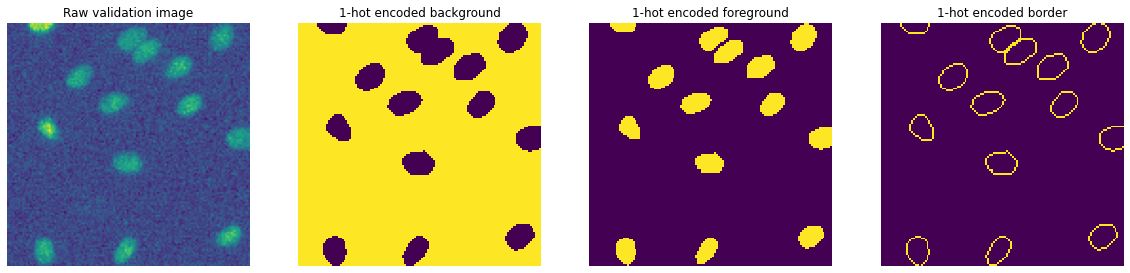

In [46]:
sample = 0
plt.figure(figsize=(20,5))
plt.subplot(1,4,1)
plt.imshow(X[sample,...,0])
plt.axis('off')
plt.title('Raw validation image')
plt.subplot(1,4,2)
plt.imshow(Y[sample,...,0], vmin=0, vmax=1, interpolation='nearest')
plt.axis('off')
plt.title('1-hot encoded background')
plt.subplot(1,4,3)
plt.imshow(Y[sample,...,1], vmin=0, vmax=1, interpolation='nearest')
plt.axis('off')
plt.title('1-hot encoded foreground')
plt.subplot(1,4,4)
plt.imshow(Y[sample,...,2], vmin=0, vmax=1, interpolation='nearest')
plt.axis('off')
plt.title('1-hot encoded border');

In [13]:
train_batch_size = 128
train_steps_per_epoch = 

In [52]:
conf = DenoiSegConfig(X, unet_kern_size=3, n_channel_out=4, relative_weights = [1.0,1.0,5.0],
                      train_steps_per_epoch=int(X.shape[0]/128), train_epochs=15, 
                      batch_norm=True, train_batch_size=128, unet_n_first = 32, 
                      unet_n_depth=4, denoiseg_alpha=0.5, train_tensorboard=False)

vars(conf)

{'means': ['13.494209'],
 'stds': ['20.886541'],
 'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 4,
 'train_loss': 'denoiseg',
 'unet_n_depth': 4,
 'relative_weights': [1.0, 1.0, 5.0],
 'unet_kern_size': 3,
 'unet_n_first': 32,
 'unet_last_activation': 'linear',
 'probabilistic': False,
 'unet_residual': False,
 'unet_input_shape': (None, None, 1),
 'train_epochs': 15,
 'train_steps_per_epoch': 237,
 'train_learning_rate': 0.0004,
 'train_batch_size': 128,
 'train_tensorboard': False,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'train_reduce_lr': {'monitor': 'val_seg_loss', 'factor': 0.5, 'patience': 10},
 'batch_norm': True,
 'n2v_perc_pix': 1.5,
 'n2v_patch_shape': (64, 64),
 'n2v_manipulator': 'uniform_withCP',
 'n2v_neighborhood_radius': 5,
 'denoiseg_alpha': 0.5}

In [53]:
model_name = 'DenoiSeg_DSB18_n10'
basedir = 'models'
model = DenoiSeg(conf, model_name, basedir)

In [54]:
history = model.train(X, Y, (X_val, Y_val))


61 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 670/670 [00:07<00:00, 94.06it/s]




Epoch 1/15
237/237 [==============================] - 110s 464ms/step - loss: 0.1574 - denoiseg: 0.1574 - seg_loss: 0.0109 - denoise_loss: 0.1464 - seg_denoise_ratio: 0.0187 - val_loss: 0.5146 - val_denoiseg: 0.5146 - val_seg_loss: 0.3905 - val_denoise_loss: 0.1240 - val_seg_denoise_ratio: 0.9716
Epoch 2/15
237/237 [==============================] - 94s 398ms/step - loss: 0.1327 - denoiseg: 0.1327 - seg_loss: 0.0059 - denoise_loss: 0.1268 - seg_denoise_ratio: 0.0185 - val_loss: 0.3718 - val_denoiseg: 0.3718 - val_seg_loss: 0.2440 - val_denoise_loss: 0.1278 - val_seg_denoise_ratio: 0.9716denoise_loss: 0.1277 - seg_denoise_ - ETA: 39s - loss: 0.1337 - denoiseg: 0.1337 - seg_loss: 0.0061 - denoise_loss: 0.1276 - seg_d - ETA: 31s - loss: 0.1336 - denoiseg: 0.1336 - seg_loss: 0.0060 - denoise_loss: 0.1276 - seg_denoi - ETA: 25s - loss: 0.1334 - denoiseg: 0.1334 - seg_loss: 0.0060 - denoise_loss: 0.1274 - seg_denoise_ratio: 0.017 - ETA: 25s - loss: 0.1334 - denoiseg: 0.1334 - seg_loss: 0.0

In [55]:
history.history.keys()

dict_keys(['val_loss', 'val_denoiseg', 'val_seg_loss', 'val_denoise_loss', 'val_seg_denoise_ratio', 'loss', 'denoiseg', 'seg_loss', 'denoise_loss', 'seg_denoise_ratio', 'lr'])

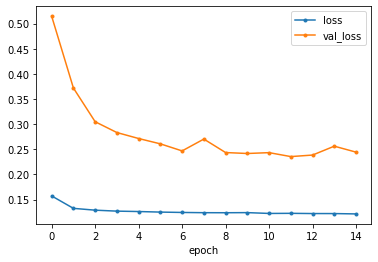

In [56]:
plot_history(history, ['loss', 'val_loss'])

## Computing Threshold Value
The network predicts 4 output channels:
1. The denoised input.
2. The foreground likelihoods.
3. The background likelihoods.
4. The border likelihoods.

We will threshold the foreground prediction image to obtain object segmentations. The optimal threshold is determined on the validation data. Additionally we can optimize the threshold for a given measure. In this case we choose the Average Precision (AP) measure.

In [63]:
threshold, val_score = model.optimize_thresholds(val_images.astype(np.float32), val_masks, measure=measure_precision())

print("The higest score of {} is achieved with threshold = {}.".format(np.round(val_score, 3), threshold))

Computing best threshold: 


Score for threshold = 0.10 is 0.6281
Score for threshold = 0.15 is 0.6775
Score for threshold = 0.20 is 0.7000
Score for threshold = 0.25 is 0.7066
Score for threshold = 0.30 is 0.6982
Score for threshold = 0.35 is 0.6901
Score for threshold = 0.40 is 0.6815
Score for threshold = 0.45 is 0.6627
Score for threshold = 0.50 is 0.6458
Score for threshold = 0.55 is 0.6101
Score for threshold = 0.60 is 0.5836
Score for threshold = 0.65 is 0.5557
Score for threshold = 0.70 is 0.5210
Score for threshold = 0.75 is 0.4764
Score for threshold = 0.80 is 0.4048
Score for threshold = 0.85 is 0.2997
Score for threshold = 0.90 is 0.1322
Score for threshold = 0.95 is 0.0311
Score for threshold = 1.00 is 0.0000

The higest score of 0.707 is achieved with threshold = 0.25.


## Test Data
Finally we load the test data and run the prediction.

In [65]:
test_data =  np.load('data/DSB2018_{}/test/test_data.npz'.format(noise_level), allow_pickle=True)
test_images = test_data['X_test']
test_masks = test_data['Y_test']

In [69]:
predicted_images, precision_result = model.predict_label_masks(test_images, test_masks, threshold, 
                                                                   measure=measure_precision())
print("Average precision over all test images with threshold = {} is {}.".format(threshold, np.round(precision_result, 3)))

Average precision over all test images with threshold = 0.25 is 0.644.
